<a href="https://colab.research.google.com/github/minal233/-Dynamic-Asset-Allocation-with-Sector-Constraints-A-Portfolio-Optimization-Approach/blob/main/Portfolio_Optimization_Equal_Weight_Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ta
!pip install PyPortfolioOpt

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=76e22397afd5b3107f1c69b15818f3044b6fe4c96a5d50d044c5f77d6ebd92da
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 8.0 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta import add_all_ta_features
from sklearn.preprocessing import StandardScaler
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt.risk_models import CovarianceShrinkage
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Step 1: Data Collection
def fetch_data(tickers, start_date='2015-01-01', end_date='2025-04-01'):
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    ohlc = data[['Open', 'High', 'Low', 'Close']].dropna()
    volumes = data['Volume'].dropna()
    ohlc.index = ohlc.index.tz_localize(None)
    volumes.index = volumes.index.tz_localize(None)

    vix = yf.download('^VIX', start=start_date, end=end_date, progress=False)['Close']
    vix.index = vix.index.tz_localize(None)
    vix.name = 'VIX'

    valid_tickers = []
    for ticker in tickers:
        ticker_data = ohlc.xs(ticker, level=1, axis=1)
        if len(ticker_data) < 252:
            continue
        else:
            valid_tickers.append(ticker)

    return ohlc, volumes, vix, valid_tickers

In [ ]:
# Step 2: Feature Engineering
def engineer_features(ohlc, volumes, vix, min_rows=252):
    features_dict = {}
    for ticker in ohlc.columns.levels[1]:
        ticker_data = ohlc.xs(ticker, level=1, axis=1)
        ticker_volume = volumes[ticker]

        df = pd.DataFrame({
            'open': ticker_data['Open'],
            'high': ticker_data['High'],
            'low': ticker_data['Low'],
            'close': ticker_data['Close'],
            'volume': ticker_volume
        }).dropna()

        if len(df) < min_rows:
            continue

        df.index = df.index.tz_localize(None)

        df['historical_return'] = df['close'].pct_change(63).fillna(0)

        features_dict[ticker] = df

    return features_dict


In [ ]:
def calculate_historical_returns(features_dict):
    predictions = {}
    for ticker, df in features_dict.items():
        predictions[ticker] = df['historical_return']

    return pd.DataFrame(predictions).dropna()


In [ ]:
# Step 4: Portfolio Optimization with Volatility Constraint
def optimize_portfolio(pred_returns, prices, min_data_points=252, max_volatility=0.18):
    if len(prices) < min_data_points:
        raise ValueError(f"Not enough data points ({len(prices)}) to estimate covariance matrix")

    prices = prices.fillna(method='ffill').dropna()

    returns = prices.pct_change().dropna()
    returns = returns.clip(lower=-0.1, upper=0.1)

    cs = CovarianceShrinkage(prices)
    cov_matrix = cs.shrunk_covariance()

    expected_ret = pred_returns.iloc[-1]
    expected_ret = expected_ret.reindex(prices.columns).dropna()
    if expected_ret.empty:
        raise ValueError("No matching tickers between expected returns and prices")

    expected_ret = expected_ret / 63

    if not np.issubdtype(expected_ret.dtype, np.number):
        raise ValueError(f"Expected returns contain non-numeric values: {expected_ret}")

    ef = EfficientFrontier(expected_ret, cov_matrix, weight_bounds=(0, 1))

    sector_mapper = {
        'AAPL': 'Tech', 'MSFT': 'Tech', 'GOOGL': 'Tech', 'AMZN': 'Tech',
        'JPM': 'Financials', 'V': 'Financials',
        'JNJ': 'Healthcare', 'PG': 'Consumer', 'XOM': 'Energy', 'T': 'Telecom'
    }
    sector_lower = {'Tech': 0.2, 'Financials': 0.0, 'Healthcare': 0.0, 'Consumer': 0.0, 'Energy': 0.0, 'Telecom': 0.0}
    sector_upper = {'Tech': 0.8, 'Financials': 0.6, 'Healthcare': 0.6, 'Consumer': 0.6, 'Energy': 0.5, 'Telecom': 0.5}
    ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

    try:
        target_return = float(expected_ret.mean()) + 0.0001
        ef.efficient_return(target_return)
        weights = ef.clean_weights()
        weights_array = np.array([weights[ticker] for ticker in expected_ret.index])
        portfolio_vol = np.sqrt(np.dot(weights_array.T, np.dot(cov_matrix * 252, weights_array)))
        if portfolio_vol > max_volatility:
            ef = EfficientFrontier(expected_ret, cov_matrix, weight_bounds=(0, 1))
            ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
            daily_vol_target = max_volatility / np.sqrt(252)
            ef.efficient_risk(daily_vol_target)
            weights = ef.clean_weights()
    except Exception as e:
        weights = {ticker: 1/len(expected_ret) for ticker in expected_ret.index}

    tech_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
    tech_weight = sum(weights[ticker] for ticker in tech_tickers)
    if tech_weight < 0.2:
        shortfall = 0.2 - tech_weight
        non_tech_weight = sum(weights[ticker] for ticker in weights if ticker not in tech_tickers)
        if non_tech_weight > 0:
            scale_factor = (1 - 0.2) / non_tech_weight
            for ticker in weights:
                if ticker in tech_tickers:
                    weights[ticker] = weights[ticker] * (1 + shortfall / tech_weight) if tech_weight > 0 else 0.05
                else:
                    weights[ticker] = weights[ticker] * scale_factor

    return weights


In [ ]:
# Step 5: Backtesting
def backtest_portfolio(prices, pred_returns, rebalance_freq='3M', min_data_points=252):
    portfolio_values = []
    weights_history = []
    dates_history = []
    portfolio_returns_log = []
    portfolio_value = 1.0

    common_dates = prices.index.intersection(pred_returns.index)
    if len(common_dates) == 0:
        raise ValueError("No common dates between prices and pred_returns")

    min_date = prices.index[prices.index.get_loc(common_dates[0]) + min_data_points]
    common_dates = common_dates[common_dates >= min_date]
    dates = common_dates[::63]

    for i in range(len(dates) - 1):
        start_date = dates[i]
        end_date = dates[i + 1]

        try:
            period_prices = prices.loc[start_date:end_date].dropna()
            if period_prices.empty:
                raise ValueError("No price data for period")
        except KeyError as e:
            continue

        try:
            historical_prices = prices.loc[:start_date].fillna(method='ffill')
            if len(historical_prices) < min_data_points:
                raise ValueError(f"Not enough historical data points ({len(historical_prices)})")
            weights = optimize_portfolio(
                pred_returns.loc[[start_date]],
                historical_prices,
                min_data_points=min_data_points
            )
        except Exception as e:
            continue

        daily_returns = period_prices.pct_change().dropna()
        portfolio_daily_returns = (daily_returns * pd.Series(weights)).sum(axis=1)
        portfolio_returns_log.extend(portfolio_daily_returns.tolist())

        period_value = (1 + portfolio_daily_returns).cumprod()
        if not period_value.empty:
            portfolio_value *= period_value.iloc[-1]
        portfolio_values.append(pd.Series(portfolio_value, index=period_value.index))
        weights_history.append(weights)
        dates_history.append(start_date)

    if not portfolio_values:
        raise ValueError("No valid periods for backtesting")

    portfolio_values = pd.concat(portfolio_values)

    returns = pd.Series(portfolio_returns_log, index=portfolio_values.index[:len(portfolio_returns_log)])
    sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std() if returns.std() != 0 else np.nan
    annualized_volatility = returns.std() * np.sqrt(252)
    cagr = (portfolio_values.iloc[-1] ** (252 / len(portfolio_values))) - 1 if len(portfolio_values) > 0 else np.nan
    max_drawdown = (portfolio_values / portfolio_values.cummax()).min() - 1 if not portfolio_values.empty else np.nan

    return portfolio_values, sharpe_ratio, annualized_volatility, cagr, max_drawdown, weights_history, dates_history, returns


YF.download() has changed argument auto_adjust default to True


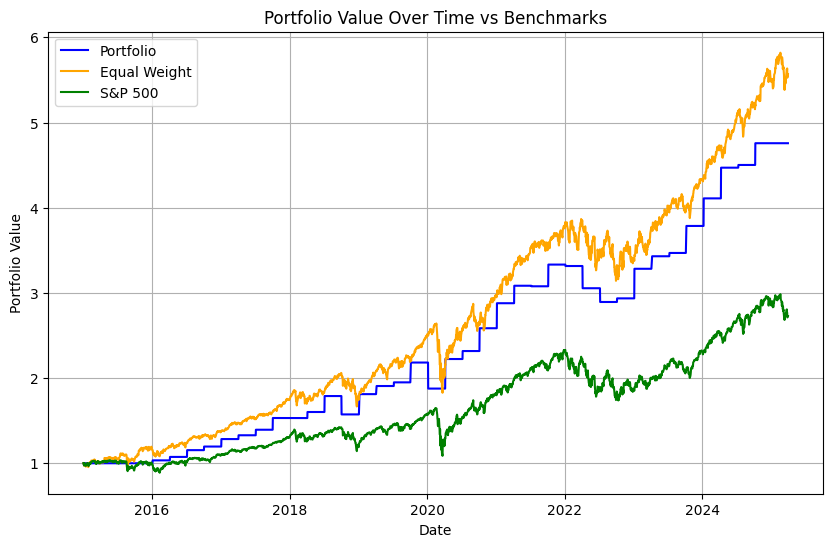

Sharpe Ratio: 1.07
Annualized Volatility: 17.75%
CAGR: 18.92%
Max Drawdown: -14.01%

First few portfolio weights:
Weights at 2016-01-04 00:00:00: {'AAPL': 0.1, 'MSFT': 0.1, 'GOOGL': 0.1, 'AMZN': 0.1, 'JPM': 0.1, 'V': 0.1, 'JNJ': 0.1, 'PG': 0.1, 'XOM': 0.1, 'T': 0.1}
Weights at 2016-04-05 00:00:00: {'AAPL': 0.1, 'MSFT': 0.1, 'GOOGL': 0.1, 'AMZN': 0.1, 'JPM': 0.1, 'V': 0.1, 'JNJ': 0.1, 'PG': 0.1, 'XOM': 0.1, 'T': 0.1}
Weights at 2016-07-05 00:00:00: {'AAPL': 0.1, 'MSFT': 0.1, 'GOOGL': 0.1, 'AMZN': 0.1, 'JPM': 0.1, 'V': 0.1, 'JNJ': 0.1, 'PG': 0.1, 'XOM': 0.1, 'T': 0.1}

Last few portfolio weights:
Weights at 2024-04-09 00:00:00: {'AAPL': 0.1, 'MSFT': 0.1, 'GOOGL': 0.1, 'AMZN': 0.1, 'JPM': 0.1, 'V': 0.1, 'JNJ': 0.1, 'PG': 0.1, 'XOM': 0.1, 'T': 0.1}
Weights at 2024-07-10 00:00:00: {'AAPL': 0.1, 'MSFT': 0.1, 'GOOGL': 0.1, 'AMZN': 0.1, 'JPM': 0.1, 'V': 0.1, 'JNJ': 0.1, 'PG': 0.1, 'XOM': 0.1, 'T': 0.1}
Weights at 2024-10-08 00:00:00: {'AAPL': 0.1, 'MSFT': 0.1, 'GOOGL': 0.1, 'AMZN': 0.1, 'JPM':

In [ ]:
# Main Execution
def main():
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JPM',
               'V', 'JNJ', 'PG', 'XOM', 'T']

    ohlc, volumes, vix, valid_tickers = fetch_data(tickers)
    prices = ohlc['Close']

    if not valid_tickers:
        raise ValueError("No valid tickers with sufficient data to proceed.")

    features_dict = engineer_features(ohlc, volumes, vix)

    if not features_dict:
        raise ValueError("No tickers with sufficient features to proceed.")

    pred_returns = calculate_historical_returns(features_dict)

    portfolio_values, sharpe_ratio, annualized_volatility, cagr, max_drawdown, weights_history, dates_history, portfolio_returns = backtest_portfolio(
        prices[valid_tickers], pred_returns
    )

    equal_weights = pd.Series(1/len(valid_tickers), index=valid_tickers)
    daily_returns = prices[valid_tickers].pct_change().dropna()
    equal_portfolio_returns = (daily_returns * equal_weights).sum(axis=1)
    equal_portfolio_value = (1 + equal_portfolio_returns).cumprod()

    sp500 = yf.download('^GSPC', start='2015-01-01', end='2025-04-01', progress=False)['Close']
    sp500.index = sp500.index.tz_localize(None)
    sp500_returns = sp500.pct_change().dropna()
    sp500_value = (1 + sp500_returns).cumprod()

    common_index = prices.index
    portfolio_values = portfolio_values.reindex(common_index).fillna(method='ffill').fillna(1)
    equal_portfolio_value = equal_portfolio_value.reindex(common_index).fillna(method='ffill').fillna(1)
    sp500_value = sp500_value.reindex(common_index).fillna(method='ffill').fillna(1)

    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_values.index, portfolio_values, label='Portfolio', color='blue')
    plt.plot(equal_portfolio_value.index, equal_portfolio_value, label='Equal Weight', color='orange')
    plt.plot(sp500_value.index, sp500_value, label='S&P 500', color='green')
    plt.title('Portfolio Value Over Time vs Benchmarks')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.savefig('portfolio_performance_with_benchmarks.png')
    plt.show()
    plt.close()

    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Annualized Volatility: {annualized_volatility:.2%}")
    print(f"CAGR: {cagr:.2%}")
    print(f"Max Drawdown: {max_drawdown:.2%}")

    print("\nFirst few portfolio weights:")
    for i in range(min(3, len(weights_history))):
        print(f"Weights at {dates_history[i]}: {weights_history[i]}")

    print("\nLast few portfolio weights:")
    for i in range(max(0, len(weights_history) - 3), len(weights_history)):
        print(f"Weights at {dates_history[i]}: {weights_history[i]}")

if __name__ == "__main__":
    main()